In [26]:
import random
from functools import partial
from pathlib import Path

from matplotlib.pyplot import figure, plot  # type: ignore
from torch import Generator, Tensor, histogram, tensor, use_deterministic_algorithms

from karpathy_series.makemore.bigrams import NGram
from karpathy_series.makemore.data import read_data
from karpathy_series.makemore.encoding.character import CharacterEncoder, CharacterSet, StringEncoder
from karpathy_series.makemore.components.recorder import FreeRecorder
from karpathy_series.makemore.components.neuro.functional import Functional
from karpathy_series.makemore.components.generation import NGramNetGenerator
from karpathy_series.makemore.components.networks.mlp import MPLNet
from karpathy_series.makemore.components.models.model import Model
from karpathy_series.makemore.components.function.loss import CrossEntropyLoss
from karpathy_series.makemore.training.data import DataSplit, TrainingSequencer, TrainingSequence
from karpathy_series.makemore.training.learning import Learner, LearningRecord

random.seed(42)

%matplotlib inline
use_deterministic_algorithms(True)
rand_generator = Generator()
seed = 2147483647


def create_generator():
    return rand_generator.manual_seed(seed)

In [4]:
data_path = Path("../../data/names.txt")
words: list[str] = read_data(data_path)
char_set = CharacterSet.from_words(words)
char_encoder = CharacterEncoder.from_charset(char_set)
string_encoder = StringEncoder(char_encoder)

context_size = 4
embedding_dims = 10
hidden_dims = 200

n_gram_gen = partial(NGram.generate, context_size, char_set.pad)
ts: TrainingSequencer = TrainingSequencer(string_encoder, char_encoder, n_gram_gen)
data_split = DataSplit.split(words, 80, 10, 10)
learning_sequence: TrainingSequence = ts.training_sequence(data_split.training, 32, True)
validation_set = ts.training_set(data_split.validation)

In [23]:
g = rand_generator.manual_seed(seed)
mpl_net = MPLNet.init(4, char_encoder.size, embedding_dims, context_size, hidden_dims, g)
model = Model(mpl_net, CrossEntropyLoss())
generator = NGramNetGenerator(char_set, string_encoder, char_encoder, mpl_net, context_size)
learning_record = LearningRecord()
print(f"{mpl_net.size()} parameters")
print(f"{mpl_net.describe()} parameters")

136151 parameters
An MLP model: Sequence [Embedding [27, 10], Flatten last 2 dims, Linear [40, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7fe48e53ecc0>, Linear [200, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7fe48e53ecc0>, Linear [200, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7fe48e53ecc0>, Linear [200, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7fe48e53ecc0>, Linear [200, 27] with bias, BatchNorm1d [27]] parameters


In [4]:
learner = Learner(model, 0.01)
learning_record += learner(learning_sequence, epochs=10, report_epochs=1)

Epoch 1 is finished with loss =  2.9445
Epoch 2 is finished with loss =  2.6925
Epoch 3 is finished with loss =  2.5297
Epoch 4 is finished with loss =  2.5009
Epoch 5 is finished with loss =  2.4586
Epoch 6 is finished with loss =  2.2887
Epoch 7 is finished with loss =  2.4005
Epoch 8 is finished with loss =  2.3603
Epoch 9 is finished with loss =  2.2377
Epoch 10 is finished with loss =  2.2285


In [6]:
print(model(*validation_set))

tensor(2.2642, grad_fn=<NllLossBackward0>)


In [7]:
for k in range(20):
    print(generator())

zoniay
mitek
zafcalz
korhqan
kelcza
swazeeh
harjnnn
hervin
chny
arell
ells
zocad
isha
su
mathel
drxayalae
jted
minnka
krelia
hashey


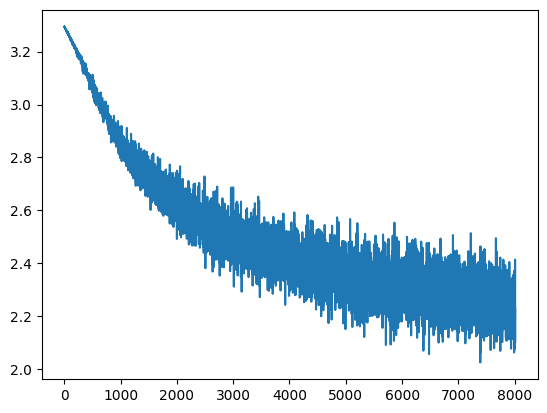

In [8]:
plot(tensor(learning_record.loss))

In [27]:
record = FreeRecorder()
loss = model(*next(learning_sequence()), record=record)
print(f"Step loss = {loss: .4f}")

Step loss =  2.2547


layer   4 Functional <built-in method tanh of type object at 0x7fe48e53ecc0>: mean -0.0006, std  0.6376, saturation  2.83%
layer   7 Functional <built-in method tanh of type object at 0x7fe48e53ecc0>: mean -0.0035, std  0.6429, saturation  2.64%
layer  10 Functional <built-in method tanh of type object at 0x7fe48e53ecc0>: mean -0.0018, std  0.6383, saturation  2.96%
layer  13 Functional <built-in method tanh of type object at 0x7fe48e53ecc0>: mean  0.0012, std  0.6410, saturation  2.76%


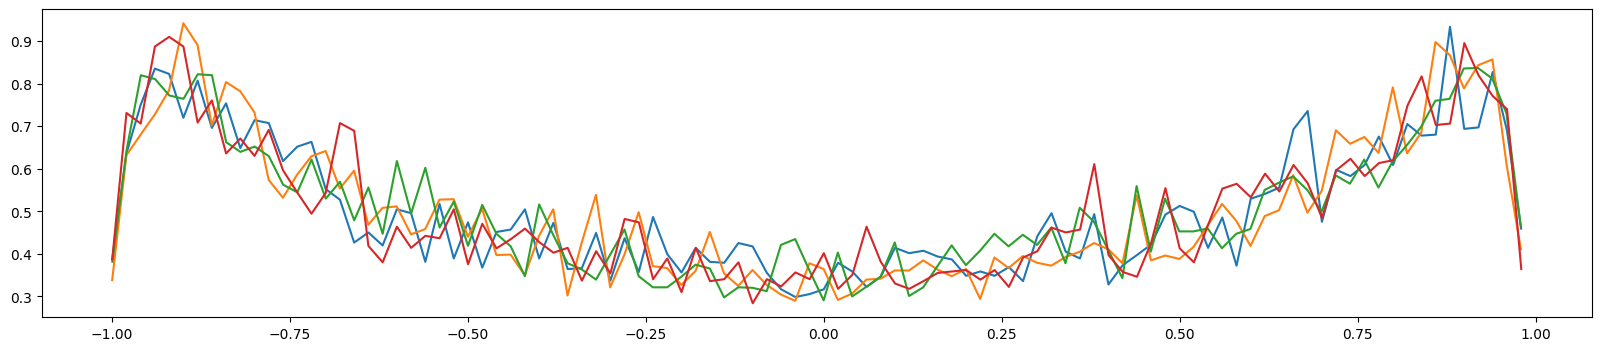

In [28]:
def saturation(out: Tensor) -> float:
    return (out.abs() > 0.97).float().mean()


figure(figsize=(20, 4))
legends = []
for i, (component, out) in enumerate(record.items()):
    if isinstance(component, Functional):
        name = component.describe()
        print(f"layer {i:>3} {name}: mean {out.mean(): .4f}, std {out.std(): .4f}, saturation {saturation(out): .2%}")
        hy, hx = histogram(out, density=True)
        plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({name})")

In [17]:
figure(figsize=(20, 4))
legends = []
for i, (component, out) in enumerate(record.items()):
    if isinstance(component, Functional):
        name = component.describe()
        if out.grad is None:
            continue
        print(f"layer {i:>3} {name}: mean {out.grad.mean(): .4f}, std {out.grad.std(): .4f}")
        hy, hx = histogram(out.grad, density=True)
        plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({name})")

<Figure size 2000x400 with 0 Axes>

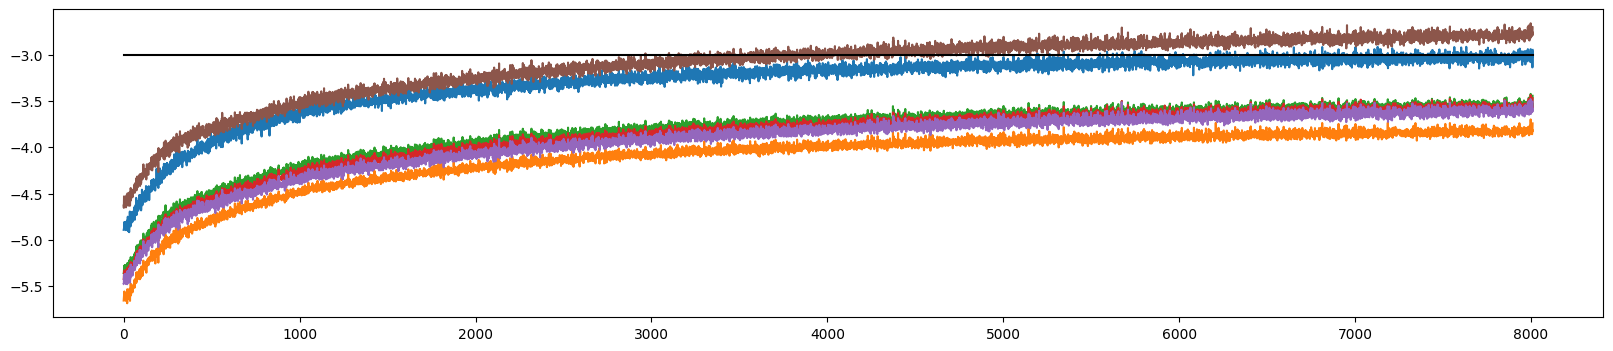

In [13]:
figure(figsize=(20, 4))
legends = []
for i, p in enumerate(mpl_net.parameters()):
    if p.ndim == 2:
        plot([learning_record.update_ratios[j][i] for j in range(len(learning_record.update_ratios))])
        legends.append(f"param {i}")
plot([0, len(learning_record.update_ratios)], [-3, -3], "k")